In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from joblib import dump
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

from utils.DrugRecords import DrugRecords
from utils.helper_functions import get_data, join_true_values_with_predicted, save_predicted_results

In [2]:
TRAINING_DATASET_PATH = "../../datasets/train_dataset.csv"
VALIDATION_DATASET_PATH = "../../datasets/validation_dataset.csv"
TEST_DATASET_PATH = "../../datasets/test_dataset.csv"
PREDICTED_RESULTS_PATH = "predicted_results.csv"

LOG_PATH = "logs/"
NUMBER_OF_EPOCHS = 15
TRAINED_MODEL = 'trained.h5'
WORD_TO_INDEXES = 'word_to_indexes'
TAGS = ['O', 'NAME', 'STRENGTH', 'PACK', 'FORM']

Prepare training data

In [3]:
training_data = get_data(TRAINING_DATASET_PATH)
training_data.head(10)

,Drug: #,Word,Tag
0,Drug: #,Word,Tag
1,Drug: 0,ventamol,NAME
2,Drug: 0,2,STRENGTH
3,Drug: 0,mg,STRENGTH
4,Drug: 0,/,STRENGTH
5,Drug: 0,5,STRENGTH
6,Drug: 0,ml,STRENGTH
7,Drug: 0,syrup,FORM
8,Drug: 0,120,PACK
9,Drug: 0,ml,PACK


In [4]:
unique_words = list(set(training_data["Word"].values))
unique_words[:10]

['protovit',
 'carbowhite',
 'vagifem',
 'tiamazol',
 'cetax',
 'mabron',
 'dilalti',
 'eprinex',
 'zinxx',
 'ciprolaks']

In [5]:
n_words = len(unique_words)
n_words

23227

In [6]:
train_drug_records = DrugRecords(training_data).get_drug_records()
train_drug_records = train_drug_records[1:] # without header

Visualize the length of drug records

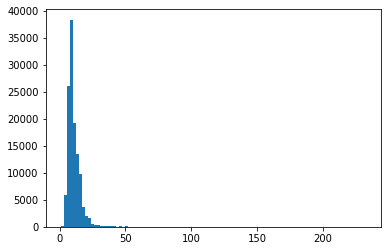

In [7]:
plt.hist([len(s) for s in train_drug_records], bins=100)
plt.show()

In [8]:
max_drug_len = 50 # value based on observation of the plot

Prepare word and tag indexes

In [9]:
unique_words_list = list(unique_words)
unique_words_list.insert(0, 'ENDPAD')

In [10]:
n_unique_words_list = len(unique_words_list)
n_unique_words_list

23228

In [11]:
word_to_indexes = {word: i for i, word in enumerate(unique_words_list)}

dump(word_to_indexes, WORD_TO_INDEXES)  # save created word index

['word_to_indexes']

In [12]:
n_tags = len(TAGS)
tag_to_indexes = {t: i for i, t in enumerate(TAGS)}


Index tag indexes, pad them and tranform into categorical form

In [13]:
y_train = [[tag_to_indexes[word[1]] for word in drug_record] for drug_record in train_drug_records]
y_train = pad_sequences(maxlen=max_drug_len, sequences=y_train, padding="post", value=tag_to_indexes["O"])
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]
y_train = np.array(y_train)

Index words and pad them

In [14]:
x_train = [[word_to_indexes[word[0]] for word in drug_record] for drug_record in train_drug_records]
x_train[:3]

[[10677, 10139, 17261, 16740, 18293, 5835, 17166, 8121, 5835],
 [4974, 6383, 13860, 6854, 3413, 17261, 3615, 18237],
 [10347, 7682, 3615, 17261, 13538, 10869, 4766, 16233, 14007]]

In [15]:
x_train = pad_sequences(maxlen=max_drug_len, sequences=x_train, padding="post", value=word_to_indexes["ENDPAD"])

Prepare evaluation data

In [16]:
eval_data = get_data(VALIDATION_DATASET_PATH)
eval_data.head(10)

,Drug: #,Word,Tag
0,Drug: #,Word,Tag
1,Drug: 0,carivalan,NAME
2,Drug: 0,blist,O
3,Drug: 0,56,PACK
4,Drug: 0,stk,PACK
5,Drug: 0,filmtabl,FORM
6,Drug: 0,12,STRENGTH
7,Drug: 0,.,STRENGTH
8,Drug: 0,5,STRENGTH
9,Drug: 0,mg,STRENGTH


Index words and tags by created indexers and pad them

In [17]:
eval_drug_records = DrugRecords(eval_data).get_drug_records()
eval_drug_records = eval_drug_records[1:]


In [18]:
x_val = [[word_to_indexes.get(word[0], n_unique_words_list) for word in drug_record] for drug_record in eval_drug_records]
x_val = pad_sequences(maxlen=max_drug_len, sequences=x_val, padding="post", value=word_to_indexes['ENDPAD'])

In [19]:
y_val = [[tag_to_indexes[word[1]] for word in drug_record] for drug_record in eval_drug_records]
y_val = pad_sequences(maxlen=max_drug_len, sequences=y_val, padding="post", value=tag_to_indexes["O"])
y_val = [to_categorical(i, num_classes=n_tags) for i in y_val]
y_val = np.array(y_val)

Create the model

In [20]:
model = Sequential()
model.add(Embedding(
    input_dim=n_unique_words_list + 1,
    output_dim=50,
    input_length=max_drug_len,
    mask_zero=True
))

model.add(LSTM(units=36, return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

summary = model.summary()
summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            1161450   
_________________________________________________________________
lstm (LSTM)                  (None, 50, 36)            12528     
_________________________________________________________________
dropout (Dropout)            (None, 50, 36)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 5)             185       
Total params: 1,174,163
Trainable params: 1,174,163
Non-trainable params: 0
_________________________________________________________________


Define log directory for saving training results and early-stopping method

In [21]:
log_dir = LOG_PATH + datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
             tf.keras.callbacks.ModelCheckpoint(TRAINED_MODEL, save_best_only=True, save_weights_only=False)]


Train the model

In [22]:
%%time

model.fit(x_train,
          y_train,
          epochs=NUMBER_OF_EPOCHS,
          validation_data=(x_val, y_val),
          verbose=2,
          callbacks=callbacks
         )

model.history

Epoch 1/15
3834/3834 - 93s - loss: 0.0468 - accuracy: 0.2337 - val_loss: 0.0262 - val_accuracy: 0.2423
Epoch 2/15


KeyboardInterrupt: 

Evaluation on validation data

In [ ]:
loss, acc = model.evaluate(np.array(x_val), y_val, verbose=2)
print('Accuracy: {:5.2f}%'.format(100 * acc))

Evaluation on test data

In [ ]:
test_data = get_data(TEST_DATASET_PATH)

test_drug_records = DrugRecords(test_data).get_drug_records()
test_drug_records = test_drug_records[1:]

In [ ]:
x_test = [[word_to_indexes.get(word[0], n_unique_words_list) for word in drug_record] for drug_record in test_drug_records]
x_test = pad_sequences(maxlen=max_drug_len, sequences=x_test, padding="post", value=word_to_indexes['ENDPAD'])


y_test = [[tag_to_indexes[word[1]] for word in drug_record] for drug_record in test_drug_records]
y_test = pad_sequences(maxlen=max_drug_len, sequences=y_test, padding="post", value=tag_to_indexes["O"])
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]


In [ ]:
loss, acc = model.evaluate(np.array(x_test), y_test, verbose=2)
print('Accuracy: {:5.2f}%'.format(100 * acc))

In [ ]:
predicted_values = model.predict(np.array(x_val))
predicted_values = np.argmax(predicted_values, axis=-1)

zipped = []
for i, sentence in enumerate(eval_drug_records):
    for w, pred in zip(sentence, predicted_values[i]):
        zipped.append((w[1], TAGS[pred]))

y_true = pd.Series([z[0] for z in zipped])
y_pred = pd.Series([z[1] for z in zipped])

Cross-validation matrix on a test data

In [ ]:
cross_tab_values = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
cross_tab_values

In [ ]:
cross_tab_percentage = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted']).round(6)*100
cross_tab_percentage

In [ ]:
plt.figure(figsize=(10, 5))
sns_plot = sns.heatmap(cross_tab_percentage,annot=True,fmt='.4g', cmap=sns.cubehelix_palette(200, start=2, rot=0, dark=0, light=.95, reverse=False))

sns_plot.figure.savefig("lstmMatrix.png")

Save predicted results into csv file

In [ ]:
joined_values = join_true_values_with_predicted(test_drug_records, predicted_values)
joined_values[:2]


In [ ]:
save_predicted_results(joined_values, PREDICTED_RESULTS_PATH)


In [ ]:
%load_ext tensorboard